ode
keff 0.0025
kon=0.0125,ka=0.0025,kd=2.51,keff=0.0025,kfactor=0.000996
spa
keff 0.004157787873376901
kon=0.00752,ka=0.00416,kd=2.51,keff=0.00416,kfactor=0.00166
spamean 40.2587058824
ode
keff 0.0025
kon=0.0125,ka=0.0025,kd=0.0126,keff=0.0025,kfactor=0.248
spa
keff 0.004157787873376901
kon=0.00752,ka=0.00621,kd=0.0126,keff=0.00416,kfactor=0.494
spamean 37.2415686275


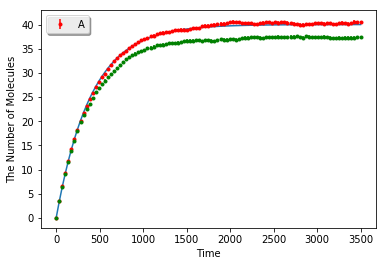

In [6]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

simrun=500#0#0
duration = 3500
nproc=None
L=2#cbrt(10)
Nas = 5*L**3
Nb=1*L**3
k0= 0.1
method='multiprocessing'
rm=0.1
obss=[]
for D in [1,0.005]:
    def write(name,obs):
        try:
            f=open(name,'w')
            data = np.array(obs.data()).T
            np.savetxt(name,np.column_stack([data[0],data[1]]),delimiter=',',fmt='%s')
            f.close()        
            print('saving into',name)        
            e=open(name+'_err','w')        
            err = np.array(obs.error()).T        
            np.savetxt(name+'_err',np.column_stack([err[0],err[1]]),delimiter=',',fmt='%s')
            e.close()
            print('saving into',name+'_err')
        except AttributeError:
            print('no error')



    def singlerun(solver='ode',intrinsic=False,simrun=1):   
        print(solver)
        V = L**3 
        M = max(int(min(cbrt(Nas), L / (2 * rm))), 3)
        if solver=='spa':
            solver=("spatiocyte",rm)
            V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm)
        elif solver=='egfrd':
            solver = ('egfrd', Integer3(M, M, M)) 

        kon=k0/V        
        keff = kon*V*V/Nas/Nb
        print('keff',keff)
        kd = 4*np.pi*rm*2*D
        ka = keff*kd/(kd-keff)
        assert(ka>0)
        with species_attributes():
            A | {'D': D, 'radius':rm}
            B | {'D': 0, 'radius':rm}

        with reaction_rules():
            ~A > A | kon
            A + B >B | (ka if intrinsic else keff)
        m = get_model()

        #print('av={:.3},intrinsic={}'.format(float(V),intrinsic))
        print('kon={:.3},ka={:.3},kd={:.3},keff={:.3},kfactor={:.3}'.format(kon,(ka if intrinsic else keff),kd,keff,ka/kd))
        if simrun >1    :
            obs=ensemble.ensemble_simulations(duration,n=simrun, y0={'B':Nb},model=m, solver=solver,volume=ones()*L,species_list=["A"],return_type='observer',nproc=nproc,method=method)#,return_type="observer")
        else:
            obs=run_simulation(duration,model=m,y0={'B':Nb},return_type='observer',species_list=['A'],solver=solver,volume=ones()*L)
        return obs

    obs1=singlerun('ode',False,1)
    obs2=singlerun('spa',True,simrun)
    data2 = np.array(obs2.data()).T
    print('spamean',np.mean(data2[1][50:]))    
    obss.append(obs2)
    #obs3=singlerun('egfrd',True,simrun)
    #obs4=singlerun('gillespie',False,simrun)
    #write('/home/chew/outputdata/sturrock_bd_ode_rm{:.3}_Nas5'.format(rm),obs1)
    #write('/home/chew/outputdata/sturrock_bd_spa_rm{:.3}_Nas5_10k'.format(rm),obs2)
    #write('/home/chew/outputdata/sturrock_bd_egfrd_rm{:.3}_Nas5_10k'.format(rm),obs3)
viz.plot_number_observer(obss[0],'r.',obss[1],'g.',obs1,'k-')#,obs3,'k-')    